# Removal of cell-cycle and sex covariates (robustness of SiFT kernels)


Given the dataset of Drosophila myoblasts [[1]](https://doi.org/10.7554/eLife.61276) we showcase robustness of performance of different `SiFT` kernels.

[[1] Everetts, N. J., Worley, M. I., Yasutomi, R., Yosef, N., & Hariharan, I. K. (2021). Single-cell transcriptomics of the Drosophila wing disc reveals instructive epithelium-to-myoblast interactions. Elife, 10, e61276.](https://doi.org/10.7554/eLife.61276)

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import anndata
import pandas as pd
import scanpy as sc
import numpy as np

import os
import sys
import seaborn as sns 
import matplotlib.pyplot as plt
import time
from scipy.sparse import issparse

import sift

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


In [42]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
sys.path.append("../../")
from paths import DATA_DIR, FIG_DIR

## Set Parameteres

In [5]:
DATA_DIR = DATA_DIR / "nuisance_drosophila"
FIG_DIR = FIG_DIR / "nuisance_drosophila"

In [6]:
fontsize = 25
size = 4
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True
plt.rcParams["figure.figsize"] = (size, size)

plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 500
plt.rcParams["axes.titlepad"] = 8.0
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["axes.labelweight"] = 500
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.labelpad"] = 6.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


plt.rcParams["font.size"] = fontsize
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', "Computer Modern Sans Serif", "DejaVU Sans"]
plt.rcParams['font.weight'] = 500

plt.rcParams['xtick.labelsize'] = fontsize-4
plt.rcParams['xtick.minor.size'] = 1.375
plt.rcParams['xtick.major.size'] = 2.75
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['xtick.minor.pad'] = 2

plt.rcParams['ytick.labelsize'] = fontsize-4
plt.rcParams['ytick.minor.size'] = 1.375
plt.rcParams['ytick.major.size'] = 2.75
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['ytick.minor.pad'] = 2

plt.rcParams["legend.fontsize"] = fontsize+4
plt.rcParams['legend.handlelength'] = 1.4 
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.scatterpoints'] = 1
plt.rcParams['legend.frameon'] = False

plt.rcParams['lines.linewidth'] = 1.7

DPI = 300

sns.set(rc={"figure.dpi":300, "savefig.dpi":300})
plt.style.use("seaborn-whitegrid")
sns.set_style("whitegrid", {"xtick.direction": "out", "xtick.major.size": 3.0, "xtick.minor.size": 3.0,
                            "ytick.color": ".15", "ytick.direction": "out", "ytick.major.size": 3.0, 
                            "ytick.minor.size": 3.0, "font": ["DejaVu Sans"], "font.scale": 1, 
                            "legend.frameon":"True"})

In [7]:
method_colors = ["#5C88DAFF", "#84BD00FF", "#FFCD00FF", "#7C878EFF"] 
coupled_method_colors = ["#5C88DAFF", "#5C88DA99", "#84BD00FF",  "#84BD0099", "#FFCD00FF", "#7C878EFF"]

## Helper functions

### Set adata colors

In [8]:
def set_adata_colors(adata):
    # set sex
    adata.uns["sex_colors"] = list(sns.color_palette("colorblind", 2).as_hex()[::-1])
    
    # set phase
    adata.obs["phase"] = adata.obs["phase"].astype("category")
    adata.obs["phase"] = adata.obs["phase"].cat.reorder_categories(['G1',  'S', 'G2M'])
    
    colors_ = list(sns.color_palette("Paired", 6).as_hex())
    adata.uns["phase_colors"] = [colors_[1], colors_[3], colors_[5]]
    
    # set batch
    adata.obs["batch_str"] = adata.obs["batch"].copy()
    adata.obs["batch_str"] = adata.obs["batch_str"].cat.rename_categories({
        '96hr_1': "96hr (1)", 
        '96hr_2': "96hr (2)", 
        '120hr_1': "120hr (1)", 
        '120hr_2': "120hr (2)", 
    })
    adata.uns["batch_str_colors"] = ["#92aeb3", "#c9c89d", "#999999", "#392b2b"]

    # set phase-sex
    adata.obs["phase_sex"] = adata.obs["phase"].astype(str) + "_" + adata.obs["sex"].astype(str)
    adata.obs["phase_sex"] = adata.obs["phase_sex"].astype("category")
    adata.obs["phase_sex"] = adata.obs["phase_sex"].cat.reorder_categories([
        'G1_female',  'G1_male', 
        'S_female',  'S_male', 
        'G2M_female',  'G2M_male', 
    ])
    adata.obs["phase_sex"] = adata.obs["phase_sex"].cat.rename_categories({
        'G1_female' : "G1 (f)",  
        'G1_male': "G1 (m)",
        'S_female': "S (f)",  
        'S_male': "S (m)",
        'G2M_female': "G2M (f)",
        'G2M_male': "G2M (m)", 
    })
    adata.uns["phase_sex_colors"] = list(sns.color_palette("Paired", 6).as_hex())
    

    
    return adata

## Setting parameteres

In [9]:
# list of sex genes and cell cycle genes we will be conditioning on
sex_genes = ["lncRNA:roX1", "lncRNA:roX2", "Sxl", "msl-2"]

cell_cycle_genes = ['PCNA', 'dnk', 'RnrS', 'RnrL', 'Claspin', 'Mcm5', 'Caf1-180',
       'RPA2', 'HipHop', 'stg', 'Mcm6', 'dup', 'WRNexo', 'Mcm7', 'dpa',
       'CG10336', 'Mcm3', 'Mcm2', 'RpA-70', 'Chrac-14', 'CG13690', 'RPA3',
       'asf1', 'DNApol-alpha73', 'CycE', 'DNApol-alpha50',
       'Kmn1', 'Lam', 'Nph', 'msd5', 'msd1', 'ctp', 'Set', 'scra',
       'Chrac-16', 'ncd', 'Ote', 'pzg', 'HDAC1', 'nesd', 'tum', 'CG8173',
       'aurB', 'feo', 'pav', 'CG6767', 'sip2', 'Det', 'Cks30A', 'CycB',
       'B52']

# list of genes we're interested in
genes_of_interest = [
    "Argk",
    "Nrt",
    "Ten-a",
    "Ten-m",
    "wb",
    "Act57B",
    "drl",
    "mid",
    "nemy",
    "lms",
    "CG11835",
    "Gyg",
    "ara",
    "tok",
    "kirre",
    "NK7.1",
    "fj",
    "beat-IIIc",
    "CG33993",
    "dpr16",
    "CG15529",
    "CG9593",
    "beat-IIb",
    "robo2",
    "Ama",
    "fz2",
    "elB",
    "noc",
    "nkd",
    "fng",
    "vg",
]

nuisance_genes = sex_genes + cell_cycle_genes

library_size = 5000

## Read pre-processed `adata`

In [10]:
methods = [
    "sift_knn",
    "sift_rbf",
    "sift_mapping",  
    "nothing"
]
fnames = {method: f"myoblasts_{method}.h5ad" for method in methods}

In [11]:
adata = sc.read(DATA_DIR + "myoblasts_annotated.h5ad")

In [12]:
adata

AnnData object with n_obs × n_vars = 19885 × 3387
    obs: 'batch', 'lncRNA:roX1_cutoff', 'lncRNA:roX2_cutoff', 'sex', 'S_score', 'G2M_score', 'phase', 'batch_str', 'phase_sex'
    uns: 'batch_str_colors', 'cell_cycle_genes', 'log1p', 'phase_colors', 'phase_sex_colors', 'sex_colors', 'sex_genes'
    layers: 'counts'

In [13]:
adatas_ = {}

# `SiFT` - knn

In [14]:
metric = "knn"
method = methods[0]
n_neighbors = 3

In [15]:
# setting up anndata for knn

adatas_[method] = adata.copy()

# then copy the expression of the nuisance gene into adata.obsm
adatas_[method].obsm["nuisance_genes"] = adatas_[method][:, nuisance_genes].X
adatas_[method].uns["nuisance_genes"] = nuisance_genes


# finally, remove the nuisance genes from the anndata
gene_subset = [g for g in adatas_[method].var_names if g not in nuisance_genes]
adatas_[method] = adatas_[method][:, gene_subset].copy()


In [16]:
start = time.perf_counter()

print(f"running {method}")    
kernel_key_ =  "nuisance_genes"     

sft = sift.SiFT(
    adata=adatas_[method],
    kernel_key=kernel_key_,
    n_neighbors=n_neighbors,
    metric=metric,
    copy=False,
)
sft.filter(
    embedding_key="X",
    pseudocount=True
    )
compute_time = time.perf_counter() - start
print(f"{method} finished in {compute_time} sec")

running sift_knn
INFO     sift: initialized a SiFTer with knn kernel.                                                               
INFO     sift: Filtering cell-cell similarity kernel using projection on `X`.                                      
INFO     sift: The data is `SiFTed`!                                                                               
         The filtered embedding is stored in `adata.X`                                                             
             Finish                                                                                                
sift_knn finished in 19.96145364176482 sec


In [17]:
sc.tl.pca(adatas_[method],)
sc.pp.neighbors(adatas_[method])
sc.tl.umap(adatas_[method])

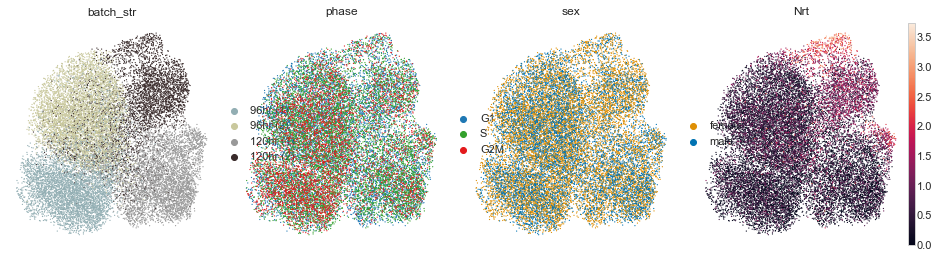

In [18]:
sc.pl.umap(
    adatas_[method],
    color=["batch_str","phase", "sex", "Nrt"],
    frameon=False,
    wspace=0,
    return_fig=True,
    )

plt.show()    

In [19]:
adatas_[method].write(DATA_DIR / f"myoblasts_{method}.h5ad")

# `SiFT` -  rbf

In [20]:
metric = "rbf"
method = methods[1]
method

'sift_rbf'

In [25]:
# setting up anndata for rbf

adatas_[method] = adata.copy()

# then copy the expression of the nuisance gene into adata.obsm
adatas_[method].obsm["nuisance_genes"] = adatas_[method][:, nuisance_genes].X
adatas_[method].uns["nuisance_genes"] = nuisance_genes


# finally, remove the nuisance genes from the anndata
gene_subset = [g for g in adatas_[method].var_names if g not in nuisance_genes]
adatas_[method] = adatas_[method][:, gene_subset].copy()


In [26]:
start = time.perf_counter()

print(f"running {method}")    
kernel_key_ =  "nuisance_genes"     

sft = sift.SiFT(
    adata=adatas_[method],
    kernel_key=kernel_key_,
    kernel_params= {"ignore_self": True, "length_scale":  .5},
    metric=metric,
    copy=False,
)

sft.filter(
    embedding_key="X",
    pseudocount=False
    )
compute_time = time.perf_counter() - start
print(f"{method} finished in {compute_time} sec")


running sift_rbf
INFO     sift: initialized a SiFTer with rbf kernel.                                                               
INFO     sift: Filtering cell-cell similarity kernel using projection on `X`.                                      
INFO     sift: The data is `SiFTed`!                                                                               
         The filtered embedding is stored in `adata.X`                                                             
             Finish                                                                                                
sift_rbf finished in 1.2446214333176613 sec


In [27]:
sc.tl.pca(adatas_[method])
sc.pp.neighbors(adatas_[method])
sc.tl.umap(adatas_[method])

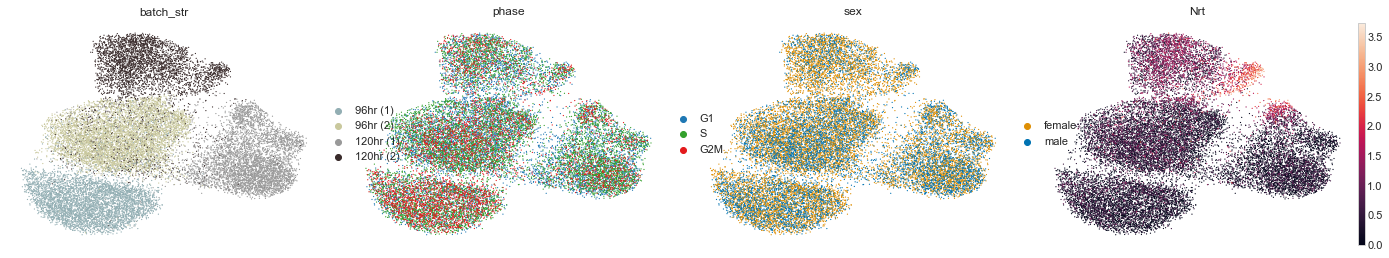

In [28]:
sc.pl.umap(
    adatas_[method],
    color=["batch_str","phase", "sex", "Nrt"],
    frameon=False,
    wspace=0,
    return_fig=True,
    )

plt.show()    

In [29]:
adatas_[method].write(DATA_DIR / f"myoblasts_{method}.h5ad")

In [ ]:
metric = "mapping"
method = methods[5]
method

In [ ]:
# setting up anndata for mapping

adatas_[method] = adata.copy()

# then copy the expression of the nuisance gene into adata.obsm
adatas_[method].obsm["nuisance_genes"] = adatas_[method][:, nuisance_genes].X
adatas_[method].uns["nuisance_genes"] = nuisance_genes


# finally, remove the nuisance genes from the anndata
gene_subset = [g for g in adatas_[method].var_names if g not in nuisance_genes]
adatas_[method] = adatas_[method][:, gene_subset].copy()


In [ ]:
start = time.perf_counter()

print(f"running {method}")    
kernel_key_ =  "phase"     

sft = sift.SiFT(
    adata=adatas_[method],
    kernel_key=kernel_key_,
    metric=metric,
    copy=False,
)

sft.filter(
    embedding_key="X",
    pseudocount=False
    )
compute_time = time.perf_counter() - start
print(f"{method} finished in {compute_time} sec")


In [ ]:
start = time.perf_counter()

print(f"running {method}")    
kernel_key_ =  "sex"     

sft = sift.SiFT(
    adata=adatas_[method],
    kernel_key=kernel_key_,
    # kernel_params= {"ignore_self": True, "length_scale":  .5},
    metric=metric,
    copy=False,
)

sft.filter(
    embedding_key="X",
    pseudocount=True
    )
compute_time = time.perf_counter() - start
print(f"{method} finished in {compute_time} sec")


In [ ]:
# fig = sft.plot_kernel(
#     groupby="phase_sex",
#     cmap="Blues",
#     show=False,
# )
    
# plt.show()

In [ ]:
sc.tl.pca(adatas_[method])
sc.pp.neighbors(adatas_[method])
sc.tl.umap(adatas_[method])

In [ ]:
sc.pl.umap(
    adatas_[method],
    color=["batch_str","phase", "sex", "Nrt"],
    frameon=False,
    wspace=0,
    return_fig=True,
    )

plt.show()    

In [ ]:
adatas_[method].write(DATA_DIR + f"myoblasts_{method}.h5ad")

# `SiFT` -  mapping

In [30]:
metric = "mapping"
method = methods[2]
method

'sift_mapping'

In [31]:
# setting up anndata for mapping

adatas_[method] = adata.copy()

# then copy the expression of the nuisance gene into adata.obsm
adatas_[method].obsm["nuisance_genes"] = adatas_[method][:, nuisance_genes].X
adatas_[method].uns["nuisance_genes"] = nuisance_genes


# finally, remove the nuisance genes from the anndata
gene_subset = [g for g in adatas_[method].var_names if g not in nuisance_genes]
adatas_[method] = adatas_[method][:, gene_subset].copy()


In [32]:
start = time.perf_counter()

print(f"running {method}")    
kernel_key_ =  "phase_sex"     

sft = sift.SiFT(
    adata=adatas_[method],
    kernel_key=kernel_key_,
    kernel_params= {"ignore_self": True},
    metric=metric,
    copy=False,
)

sft.filter(
    embedding_key="X",
    pseudocount=False
    )
compute_time = time.perf_counter() - start
print(f"{method} finished in {compute_time} sec")


running sift_mapping
INFO     sift: initialized a SiFTer with mapping kernel.                                                           
INFO     sift: Filtering cell-cell similarity kernel using projection on `X`.                                      
[KeOps] Generating code for formula Sum_Reduction(Var(0,6,0)|Var(1,6,1)-(Var(0,6,0)|Var(1,6,1))*Step(Var(4,1,2)-(Var(2,1,0)-Var(3,1,1))**2),0) ... OK
[KeOps] Generating code for formula Sum_Reduction((Var(0,1,0)*(Var(1,6,0)|Var(2,6,1)-(Var(1,6,0)|Var(2,6,1))*Step(Var(5,1,2)-(Var(3,1,0)-Var(4,1,1))**2)))*Var(6,3332,1),0) ... OK
INFO     sift: The data is `SiFTed`!                                                                               
         The filtered embedding is stored in `adata.X`                                                             
             Finish                                                                                                
sift_mapping finished in 1.9198146928101778 sec


In [33]:
sc.tl.pca(adatas_[method])
sc.pp.neighbors(adatas_[method])
sc.tl.umap(adatas_[method])

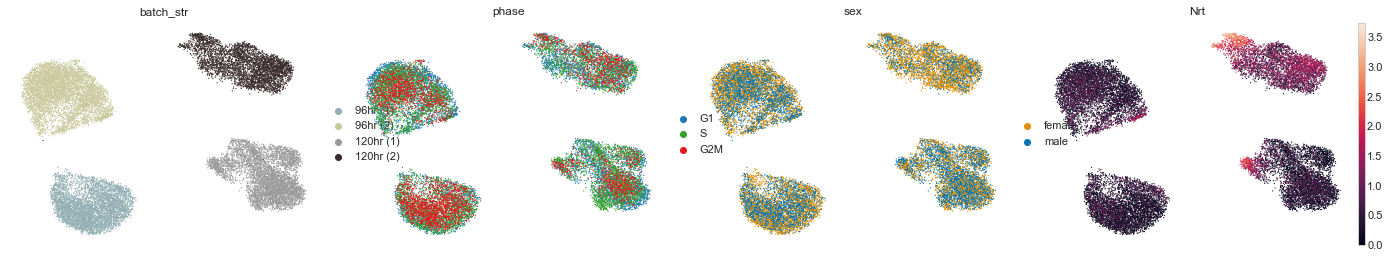

In [34]:
sc.pl.umap(
    adatas_[method],
    color=["batch_str","phase", "sex", "Nrt"],
    frameon=False,
    wspace=0,
    return_fig=True,
    )

plt.show()    

In [38]:
adatas_[method].write(DATA_DIR / f"myoblasts_{method}.h5ad")

In [ ]:
method = methods[2]

In [ ]:
# setting up anndata for scvi with conditioning on nuisance genes
adatas_[method] = adata.copy()

# then copy the expression of each nuisance gene into adata.obs where the key
# is the gene name
for g in nuisance_genes:
    exp = adatas_[method][:,g].X
    adatas_[method].obs[g] = exp.copy()

# finally, remove the nuisance genes from the anndata
gene_subset = [g for g in adatas_[method].var_names if g not in nuisance_genes]
adatas_[method] = adatas_[method][:,gene_subset].copy()

# run setup_anndata with our list of nuisance genes as our continuous covariates
scvi.model.SCVI.setup_anndata(adatas_[method],
                              continuous_covariate_keys=nuisance_genes, 
                              layer='counts')

## Train

In [ ]:
cond_model = scvi.model.SCVI(adatas_[method])

In [ ]:
cond_model.train()

## Visualization
Here we visualize the latent space of our `scVI` model trained with expression from our nuisance genes as a continuous covariate.

In [ ]:
adatas_[method].obsm["X_emb"] = cond_model.get_latent_representation()
adatas_[method].layers["X"] =  adatas_[method].X.copy()
adatas_[method].layers["X_scvi_norm"] = cond_model.get_normalized_expression(adatas_[method], library_size = library_size)

In [ ]:
# log1p scvi normalized expression
adatas_[method].layers["scvi_norm_log"] = np.log1p(adatas_[method].layers["X_scvi_norm"])
# set layer to scvi_norm_log prior to scaling and clustering
adatas_[method].X = adatas_[method].layers["scvi_norm_log"]

In [ ]:
# scale expression
sc.pp.scale(adatas_[method])

In [ ]:
sc.pp.neighbors(adatas_[method], use_rep = "X_emb")
sc.tl.umap(adatas_[method])

In [ ]:
fig = sc.pl.umap(
    adatas_[method],
    color=["batch_str", "phase", "sex", "vg"],
    frameon=False,
    wspace=0,
    return_fig=True,
    )

plt.show()

In [ ]:
adatas_[method].write(DATA_DIR / f"myoblasts_{method}.h5ad")

# Nothing

In [35]:
method = methods[-1]
method

'nothing'

In [36]:
adatas_[method] = adata.copy()
sc.pp.scale(adatas_[method])
sc.tl.pca(adatas_[method])
sc.pp.neighbors(adatas_[method])
sc.tl.umap(adatas_[method])

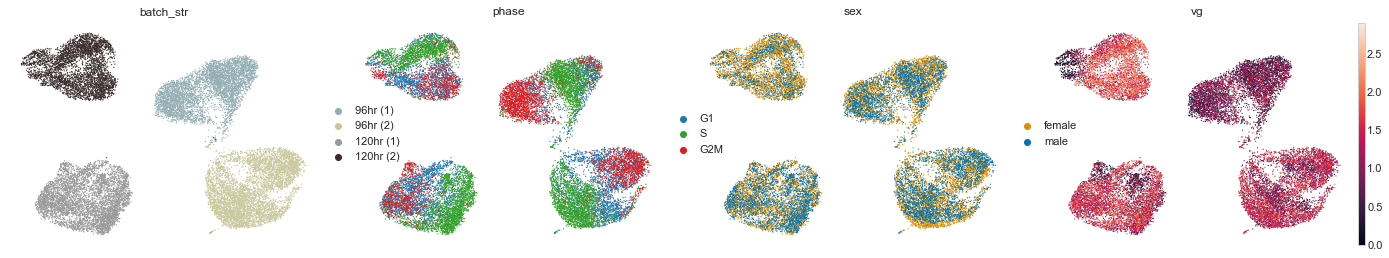

In [37]:
fig = sc.pl.umap(
    adatas_[method],
    color=["batch_str","phase", "sex", "vg"],
    frameon=False,
    wspace=0,
    return_fig=True,
)
plt.show()

In [39]:
adatas_[method].write(DATA_DIR / f"myoblasts_{method}.h5ad")

# Analysis

In [40]:
import scib

In [43]:
methods = [
    'sift_knn',
    'sift_rbf',
    'sift_mapping',
    'nothing'
]

In [ ]:
adatas_ = {}

In [ ]:
for method in methods:
    adatas_[method] = sc.read(DATA_DIR + f"myoblasts_{method}.h5ad")

## Plot data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


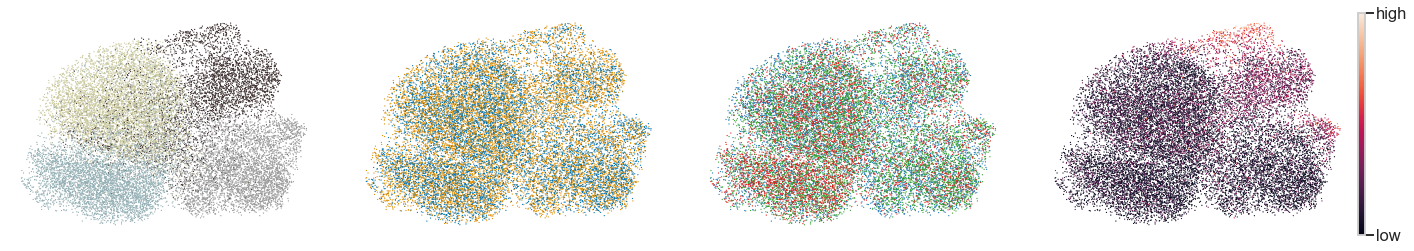

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


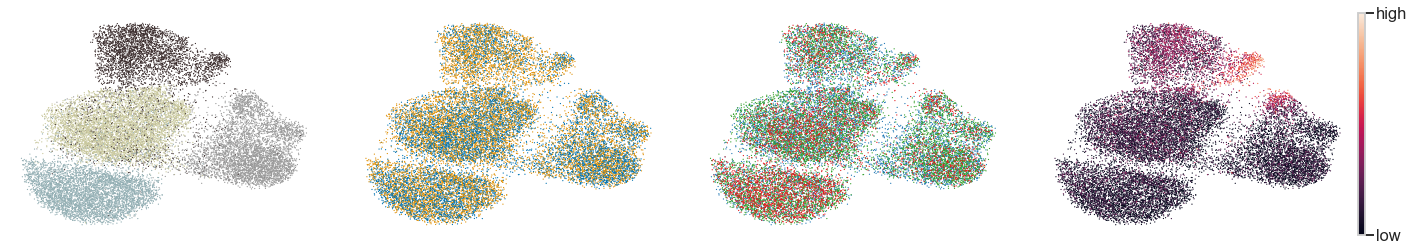

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


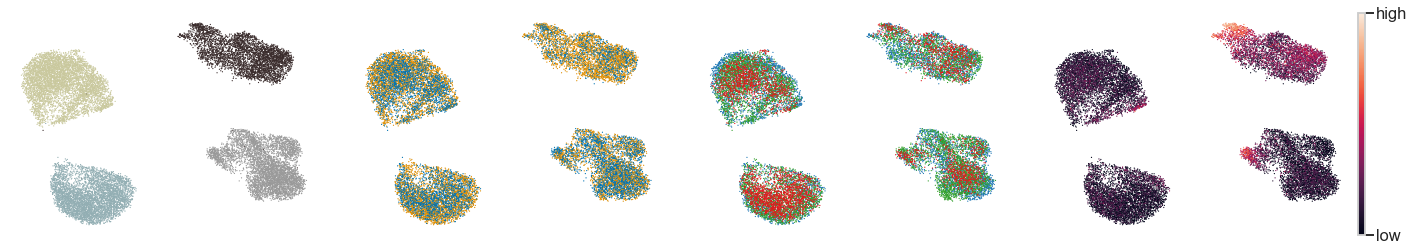

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


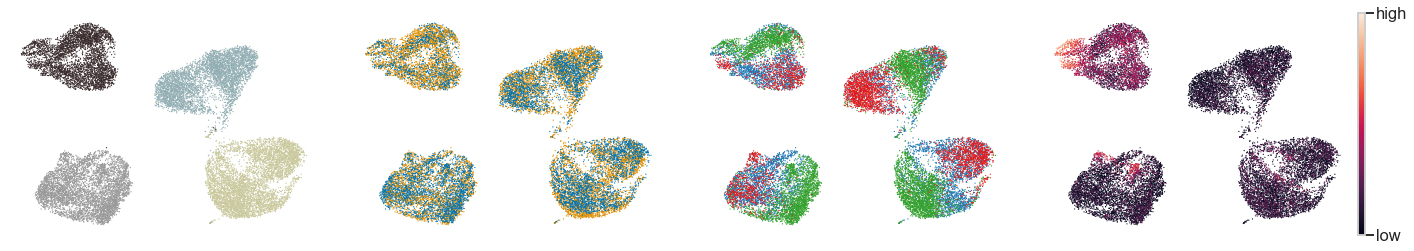

In [44]:
for key_, adata_ in adatas_.items():
    adata_ = set_adata_colors(adata_)
    fig = sc.pl.umap(
        adata_,
        color=["batch_str", "sex",  "phase", "Nrt"],
        frameon=False,
        wspace=0,
        return_fig=True,
    )
    
    for ax in fig.axes:
        ax.set_title("")
        ax.legend().remove()
    # fig.axes[0].set_title(key_, fontsize=20)
    g = fig.axes[-1].get_yaxis()
    g.set_ticks([0, 3.74])
    g.set_ticklabels(["low", "high"])
    fig.savefig(FIG_DIR / f"dros_{key_}_umap.png", bbox_inches="tight", dpi=DPI)
    plt.show()

## Quantitive analysis - `iLISI graph score` and `hvg`s

In [45]:
metrics_eval = ["ilisi",]
batch_keys = ["phase","phase_sex"]

scores = {}
scores_batch = {}
for metric_ in metrics_eval:
    for key_ in batch_keys:
        scores[f"{metric_}_{key_}"]  = {}
        scores_batch[f"{metric_}_{key_}"]  = {}

scores["hvg"] = {}
scores_batch["hvg"]  = {}

In [46]:
n_hvg = 500

methods_cmp = {
    'sift_knn': "SiFT (knn)",
    'sift_rbf': "SiFT (rbf)",
    'sift_mapping': "SiFT (mapping)",
    "nothing": "Original data"
}

In [48]:
for method in methods_cmp:
    print(method)
    print(f"eval {method}")
    cc = sc.pp.highly_variable_genes(
            adatas_[method], 
            n_top_genes=n_hvg,
            flavor = "cell_ranger",
            inplace=False
        )
    hvgs_ = adatas_[method].var_names[cc["highly_variable"]]
        
    intersect_hvg_ = hvgs_.intersection(genes_of_interest)
    scores["hvg"][f"{method}"] = len(intersect_hvg_) / len(genes_of_interest)
    score_ = scores["hvg"][f"{method}"]
    print(f"hvg score: {score_}")
    
    for batch_key in batch_keys:
        print(f"{method}-{batch_key}")
        
        # iLISI
        params = {
            "adata": adatas_[method],
            "batch_key": batch_key,
            "type_": "embed" if "X_emb" in adatas_[method].obsm else "full",
            "n_cores": 1,
            "subsample": 0.5 * 100,
        }
        
        scores[f"ilisi_{batch_key}"][f"{method}"] = scib.metrics.ilisi_graph(
            **params
        )
        score_ = scores[f"ilisi_{batch_key}"][f"{method}"]
        print(f"iLISI score: {score_}")
        
        scores_batch[f"ilisi_{batch_key}"][f"{method}"] = []
    
    scores_batch["hvg"][f"{method}"] = []
    for batch in adatas_[method].obs["batch"].cat.categories:
        adata_c = adatas_[method][adatas_[method].obs["batch"].isin([batch])].copy()
        cc = sc.pp.highly_variable_genes(
            adata_c, 
            n_top_genes=n_hvg,
            flavor = "cell_ranger",
            inplace=False
        )
        hvgs_ = adata_c.var_names[cc["highly_variable"]]

        intersect_hvg_ = hvgs_.intersection(genes_of_interest)
    
        scores_batch["hvg"][f"{method}"].append(len(intersect_hvg_) / len(genes_of_interest))
        
        score_ = scores_batch["hvg"][f"{method}"][-1]
        print(f"hvg score {batch}: {score_}")
        
        for batch_key in batch_keys:
            print(f"{method}-{batch_key}")
            # iLISI
            params = {
                "adata": adata_c,
                "batch_key": batch_key,
                "type_": "embed" if "X_emb" in adata_c.obsm else "full",
                "n_cores": 1,
                "subsample": 0.5 * 100,
            }

            scores_batch[f"ilisi_{batch_key}"][f"{method}"].append(scib.metrics.ilisi_graph(
                **params
            ))
            score_ = scores_batch[f"ilisi_{batch_key}"][f"{method}"][-1]
            print(f"iLISI score {batch}: {score_}")
      

sift_knn
eval sift_knn
hvg score: 0.41935483870967744
sift_knn-phase
iLISI score: 0.7821096167343551
sift_knn-phase_sex
iLISI score: 0.631608521454347
hvg score 96hr_1: 0.25806451612903225
sift_knn-phase
iLISI score 96hr_1: 0.7897437488622301
sift_knn-phase_sex
iLISI score 96hr_1: 0.6296920414257097
hvg score 96hr_2: 0.3870967741935484
sift_knn-phase
iLISI score 96hr_2: 0.7782551599196932
sift_knn-phase_sex
iLISI score 96hr_2: 0.6562289586283031
hvg score 120hr_1: 0.5161290322580645
sift_knn-phase
iLISI score 120hr_1: 0.6873560608133165
sift_knn-phase_sex
iLISI score 120hr_1: 0.6160588050351287
hvg score 120hr_2: 0.5483870967741935
sift_knn-phase
iLISI score 120hr_2: 0.7339219544816815
sift_knn-phase_sex
iLISI score 120hr_2: 0.537298627017117
sift_rbf
eval sift_rbf
hvg score: 0.3548387096774194
sift_rbf-phase
iLISI score: 0.7632573027727885
sift_rbf-phase_sex
iLISI score: 0.6116091422301853
hvg score 96hr_1: 0.1935483870967742
sift_rbf-phase
iLISI score 96hr_1: 0.7544082585646044
sift_

In [49]:
df_scores_batch = pd.DataFrame(scores_batch).T 
df_scores_batch = df_scores_batch.reset_index()
df_scores_batch = df_scores_batch.melt(id_vars=["index"]).rename(columns = {'index':'metric', 'value':'score', "variable":"method"}, inplace = False)
df_scores_batch[["0","1","2","3"]] = pd.DataFrame(df_scores_batch.score.tolist(), index= df_scores_batch.index)
del df_scores_batch["score"]

df_scores_batch = df_scores_batch.melt(id_vars=["metric", "method"])


### Save score

In [ ]:
df_scores_batch.to_csv(DATA_DIR + "ilisi_hvg_scores_batch_sift_kernel.csv")

### Plot score

In [ ]:
df_scores_batch = pd.read_csv(DATA_DIR + "ilisi_hvg_scores_batch_sift_kernel.csv")

In [50]:
methods_plot = {
    'sift_knn': "SiFT (knn)",
    'sift_rbf': "SiFT (rbf)",
    'sift_mapping': "SiFT (mapping)",
    "nothing": "Original data"
}

In [51]:
label_title = {"phase":"graph iLISI\n cc phase", "phase_sex": "graph iLISI\ncc phase & sex", "hvg": "HVG overlap"}

metrics_plot =  [f"ilisi_{label}" for label in ["phase", "phase_sex"]] 
metrics_plot.append("hvg")

df_scores_lim = df_scores_batch[df_scores_batch["metric"].isin(metrics_plot)].copy()
df_scores_lim.loc[:, "metric"] = df_scores_lim.loc[:, "metric"].replace({
        f"ilisi_{label}": label_title[label] for label in ["phase", "phase_sex"]
        
    }, inplace=False)

df_scores_lim.loc[:, "metric"] = df_scores_lim.loc[:, "metric"].replace({
        "hvg": "HVG overlap"
        }, inplace=False)

df_scores_lim = df_scores_lim[df_scores_lim["method"].isin(methods_plot.keys())]
df_scores_lim.loc[:, "method"] =  df_scores_lim.loc[:, "method"].replace({    
    'sift_knn': "SiFT (knn)",
    'sift_rbf': "SiFT (rbf)",
    'sift_mapping': "SiFT (mapping)",
    "nothing": "Original data"
}, inplace=False)

In [52]:
colors_sift = sns.color_palette("Blues", 3)
list(colors_sift.as_hex())
colors_sift = list(colors_sift.as_hex())[::-1] + [method_colors[-1]]
colors_sift

['#2070b4', '#6aaed6', '#c6dbef', '#7C878EFF']

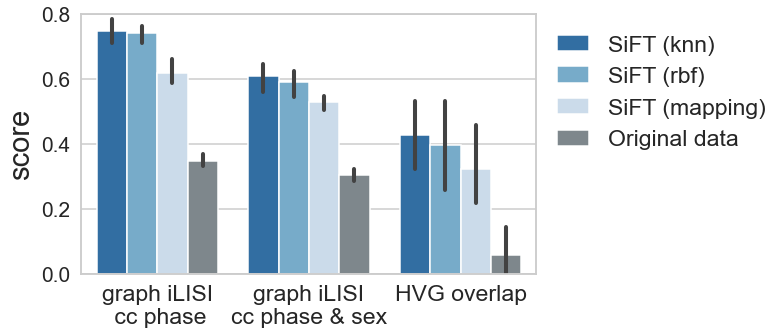

In [53]:
size = 4
fig, axs = plt.subplots(1,1, figsize=(size*2.8,size+1))

bar = sns.barplot(x="metric", 
                  y="value",
                  data=df_scores_lim, 
                  hue="method", 
                  ax=axs, 
                  palette=colors_sift)
        
leg = axs.legend(ncol=1, 
                    loc="upper left", 
                    bbox_to_anchor=(1.0, 1.0),
                    frameon=False, fontsize=fontsize-2)
plt.title("")
plt.xticks(rotation=0,  fontsize=fontsize-2)
plt.ylim(0, 0.8)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8] ,fontsize=fontsize-4)
plt.xlabel("", fontsize=fontsize-4)
plt.ylabel("score",  fontsize=fontsize+4)
plt.tight_layout()
fig.savefig(FIG_DIR / f"score_iLISI_hvg_batch_sift.png", bbox_inches="tight", dpi=DPI)
plt.show()